# SymMNA function test
last update: 15 Jan 2024  

## Introduction
This notebook test the SMNA_func

## Circuit description
The circuit below is a 2nd order band pass filter with magnetic coupling. The schematic of the circuit is shown below with each node explicity annotated.

<img src="SMNA_example.png" width="700">  

The value of K1 has been changed to 0.15. The net list for this circuit is:
```
SMNA_example.asc
V1 1 0 1
R1 3 1 1e3
R4 2 0 10e3
C1 3 0 0.01e-6
C2 2 0 0.01e-6
L1 4 0 1e-6
L2 5 0 1e-6
R2 4 3 0.5
R3 2 5 0.5
K1 L1 L2 0.15
```


In [1]:
import os
from sympy import *
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import pandas as pd
import SymMNA
init_printing()

## Symbolic MNA code 

## Load the net list

In [2]:
example_net_list = '''V1 1 0 1 
R1 3 1 1e3
R4 2 0 10e3
C1 3 0 0.01e-6
C2 2 0 0.01e-6
L1 4 0 1e-6
L2 5 0 1e-6
R2 4 3 0.5
R3 2 5 0.5
K1 L1 L2 0.15'''

In [3]:
df, df2, A, X, Z = SymMNA.smna(example_net_list)

In [4]:
# Put matricies into SymPy 
#A = Matrix(A)
X = Matrix(X)
Z = Matrix(Z)

In [5]:
equ = Eq(A*X,Z)

In [6]:
equ

⎡              v₁   v₃        ⎤       
⎢       I_V1 + ── - ──        ⎥       
⎢              R₁   R₁        ⎥       
⎢                             ⎥       
⎢     ⎛       1    1 ⎞   v₅   ⎥       
⎢  v₂⋅⎜C₂⋅s + ── + ──⎟ - ──   ⎥   ⎡0 ⎤
⎢     ⎝       R₄   R₃⎠   R₃   ⎥   ⎢  ⎥
⎢                             ⎥   ⎢0 ⎥
⎢   ⎛       1    1 ⎞   v₄   v₁⎥   ⎢  ⎥
⎢v₃⋅⎜C₁⋅s + ── + ──⎟ - ── - ──⎥   ⎢0 ⎥
⎢   ⎝       R₂   R₁⎠   R₂   R₁⎥   ⎢  ⎥
⎢                             ⎥   ⎢0 ⎥
⎢              v₃   v₄        ⎥ = ⎢  ⎥
⎢       I_L1 - ── + ──        ⎥   ⎢0 ⎥
⎢              R₂   R₂        ⎥   ⎢  ⎥
⎢                             ⎥   ⎢V₁⎥
⎢              v₂   v₅        ⎥   ⎢  ⎥
⎢       I_L2 - ── + ──        ⎥   ⎢0 ⎥
⎢              R₃   R₃        ⎥   ⎢  ⎥
⎢                             ⎥   ⎣0 ⎦
⎢             v₁              ⎥       
⎢                             ⎥       
⎢ -I_L1⋅L₁⋅s - I_L2⋅M₁⋅s + v₄ ⎥       
⎢                             ⎥       
⎣ -I_L1⋅M₁⋅s - I_L2⋅L₂⋅s + v₅ ⎦       

In [7]:
# turn the free symbols into SymPy variables
var(str(equ.free_symbols).replace('{','').replace('}',''))

## Symbolic solution

In [8]:
symbolic_solution = solve(equ,X)

The symbolic solution for the voltage at node 2 is:

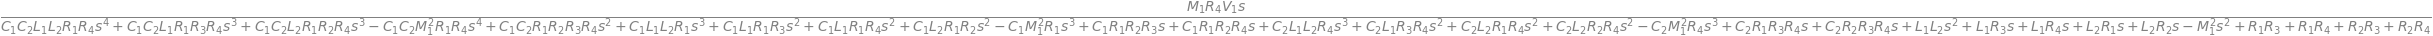

In [9]:
symbolic_solution[v2]

Built a python dictionary of element values

In [10]:
element_value_keys = []
element_value_values = []

for i in range(len(df)):
    if df.iloc[i]['element'][0] == 'F' or df.iloc[i]['element'][0] == 'E' or df.iloc[i]['element'][0] == 'G' or df.iloc[i]['element'][0] == 'H':
        element_value_keys.append(var(df.iloc[i]['element'].lower()))
        element_value_values.append(df.iloc[i]['value'])
        #print('{:s}:{:f},'.format(df.iloc[i]['element'].lower(),df.iloc[i]['value']))
    else:
        element_value_keys.append(var(df.iloc[i]['element']))
        element_value_values.append(df.iloc[i]['value'])
        #print('{:s}:{:.4e},'.format(df.iloc[i]['element'],df.iloc[i]['value']))

element_values = dict(zip(element_value_keys, element_value_values))

In [11]:
# calculate the coupling constant from the mutual inductance
element_values[M1] = element_values[K1]*np.sqrt(element_values[L1] *element_values[L2])
print('mutual inductance, M1 = {:.9f}'.format(element_values[M1]))

mutual inductance, M1 = 0.000000150


In [12]:
element_values

## Numeric solution
Substitue the element values into the equations and solve for unknown node voltages and currents. Need to set the current source, I1, to zero.

In [13]:
equ1a = equ.subs(element_values)
equ1a

⎡        I_V1 + 0.001⋅v₁ - 0.001⋅v₃        ⎤   ⎡ 0 ⎤
⎢                                          ⎥   ⎢   ⎥
⎢     v₂⋅(1.0e-8⋅s + 2.0001) - 2.0⋅v₅      ⎥   ⎢ 0 ⎥
⎢                                          ⎥   ⎢   ⎥
⎢-0.001⋅v₁ + v₃⋅(1.0e-8⋅s + 2.001) - 2.0⋅v₄⎥   ⎢ 0 ⎥
⎢                                          ⎥   ⎢   ⎥
⎢          I_L1 - 2.0⋅v₃ + 2.0⋅v₄          ⎥   ⎢ 0 ⎥
⎢                                          ⎥ = ⎢   ⎥
⎢          I_L2 - 2.0⋅v₂ + 2.0⋅v₅          ⎥   ⎢ 0 ⎥
⎢                                          ⎥   ⎢   ⎥
⎢                    v₁                    ⎥   ⎢1.0⎥
⎢                                          ⎥   ⎢   ⎥
⎢   -1.0e-6⋅I_L1⋅s - 1.5e-7⋅I_L2⋅s + v₄    ⎥   ⎢ 0 ⎥
⎢                                          ⎥   ⎢   ⎥
⎣   -1.5e-7⋅I_L1⋅s - 1.0e-6⋅I_L2⋅s + v₅    ⎦   ⎣ 0 ⎦

Solve for voltages and currents in terms of Laplace variable s.

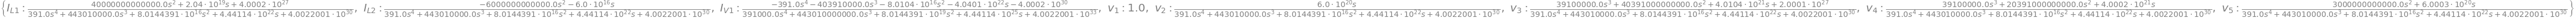

In [14]:
u1 = solve(equ1a,X)
u1

## AC analysis
Solve equations a frequency of 1.491MHz or $\omega$ equal to 9.3682292e6 radians per second, s = 9.3682292e6j.

In [15]:
equ1a_1rad_per_s = equ1a.subs({s:9.3682292e6j})
equ1a_1rad_per_s  # display the equations

⎡          I_V1 + 0.001⋅v₁ - 0.001⋅v₃           ⎤   ⎡ 0 ⎤
⎢                                               ⎥   ⎢   ⎥
⎢     v₂⋅(2.0001 + 0.093682292⋅ⅈ) - 2.0⋅v₅      ⎥   ⎢ 0 ⎥
⎢                                               ⎥   ⎢   ⎥
⎢-0.001⋅v₁ + v₃⋅(2.001 + 0.093682292⋅ⅈ) - 2.0⋅v₄⎥   ⎢ 0 ⎥
⎢                                               ⎥   ⎢   ⎥
⎢            I_L1 - 2.0⋅v₃ + 2.0⋅v₄             ⎥   ⎢ 0 ⎥
⎢                                               ⎥ = ⎢   ⎥
⎢            I_L2 - 2.0⋅v₂ + 2.0⋅v₅             ⎥   ⎢ 0 ⎥
⎢                                               ⎥   ⎢   ⎥
⎢                      v₁                       ⎥   ⎢1.0⎥
⎢                                               ⎥   ⎢   ⎥
⎢  -9.3682292⋅ⅈ⋅I_L1 - 1.40523438⋅ⅈ⋅I_L2 + v₄   ⎥   ⎢ 0 ⎥
⎢                                               ⎥   ⎢   ⎥
⎣  -1.40523438⋅ⅈ⋅I_L1 - 9.3682292⋅ⅈ⋅I_L2 + v₅   ⎦   ⎣ 0 ⎦

In [16]:
ans1 = solve(equ1a_1rad_per_s,X)
ans1

In [17]:
for name, value in ans1.items():
    print('{:5s}: mag: {:10.6f} phase: {:11.5f} deg'.format(str(name),float(abs(value)),float(arg(value)*180/np.pi)))

v1   : mag:   1.000000 phase:     0.00000 deg
v2   : mag:   0.101262 phase:   -21.01244 deg
v3   : mag:   0.101577 phase:    -5.11176 deg
v4   : mag:   0.101240 phase:    -2.44326 deg
v5   : mag:   0.101378 phase:   -18.33074 deg
I_V1 : mag:   0.000899 phase:  -179.42310 deg
I_L1 : mag:   0.009469 phase:   -89.69164 deg
I_L2 : mag:   0.009486 phase:  -111.07360 deg


## AC Sweep
Looking at node 2 voltage.

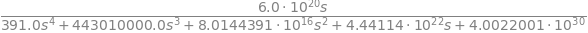

In [18]:
H = u1[v2]
H

In [19]:
num, denom = fraction(H) #returns numerator and denominator

# convert symbolic to numpy polynomial
a = np.array(Poly(num, s).all_coeffs(), dtype=float)
b = np.array(Poly(denom, s).all_coeffs(), dtype=float)
system = (a, b) # system for circuit

In [20]:
x = np.logspace(6, 6.5, 1000, endpoint=True)*2*np.pi
w, mag, phase = signal.bode(system, w=x) # returns: rad/s, mag in dB, phase in deg

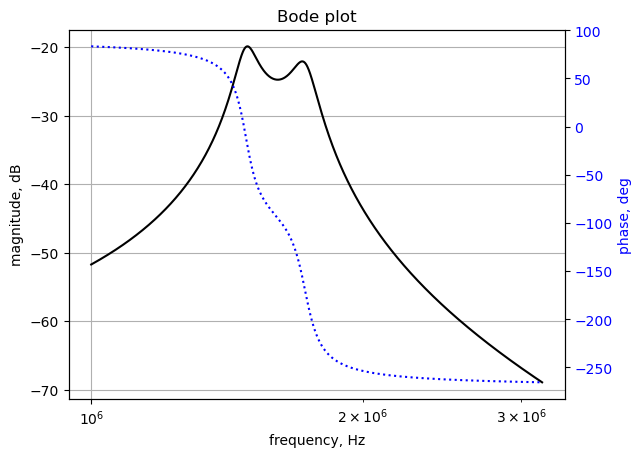

In [21]:
fig, ax1 = plt.subplots()
ax1.set_ylabel('magnitude, dB')
ax1.set_xlabel('frequency, Hz')

plt.semilogx(w/(2*np.pi), mag,'-k')    # Bode magnitude plot

ax1.tick_params(axis='y')
plt.grid()

# instantiate a second y-axes that shares the same x-axis
ax2 = ax1.twinx()
plt.semilogx(w/(2*np.pi), phase,':',color='b')  # Bode phase plot

ax2.set_ylabel('phase, deg',color='b')
ax2.tick_params(axis='y', labelcolor='b')
#ax2.set_ylim((-5,25))

plt.title('Bode plot')
plt.show()

In [22]:
print('peak: {:.2f} dB at {:.3f} MHz'.format(mag.max(),w[np.argmax(mag)]/(2*np.pi)/1e6,))

peak: -19.89 dB at 1.490 MHz
